In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [55]:
EVIDENCE_FILENAME = "estimations/raago_tobi/prior_evidence_dynamic_time.csv"
MATCHES_FILENAME = "data/aago/aago_original_filtered.adapted.csv"
PRIORS_FILENAME = "estimations/raago_tobi/priors.csv"

In [10]:
df_evidence = pd.read_csv(EVIDENCE_FILENAME, index_col="match_id")
df_evidence

,evidence
match_id,
0,1.000000e+00
1,4.707918e-10
2,9.999924e-01
3,9.999949e-01
4,1.000000e+00
...,...
3284,7.205429e-01
3285,9.726549e-01
3286,9.078378e-01


<AxesSubplot:xlabel='evidence', ylabel='Count'>

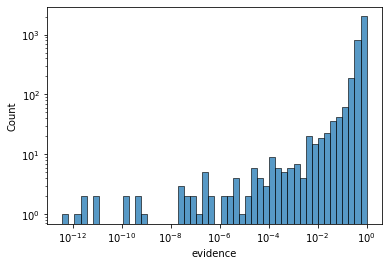

In [11]:
sns.histplot(data=df_evidence, x="evidence", bins=50, log_scale=(True,True))

In [12]:
len(df_evidence[df_evidence["evidence"] < 1e-5])

35

In [13]:
def geometric_mean(data):
    return math.exp(np.log(data).mean())

In [14]:
geometric_mean(df_evidence[df_evidence["evidence"] > 1e-5]["evidence"])

0.491816668261546

In [15]:
df_matches = pd.read_csv(MATCHES_FILENAME, index_col="id")
df_matches

,black,white,handicap,komi,winner,day,start_date,event_id
id,,,,,,,,
0,2,1,5,0.5,B,1,2012-06-26,1
1,2,1,0,6.5,W,3,2012-06-28,2
2,3,4,0,6.5,W,4,2012-06-29,3
3,4,3,0,6.5,B,5,2012-06-30,4
4,5,3,0,6.5,W,5,2012-06-30,4
...,...,...,...,...,...,...,...,...
3284,216,218,0,6.5,W,2862,2020-04-02,75
3285,53,96,0,6.5,B,2862,2020-04-02,75
3286,16,27,0,6.5,W,2862,2020-04-02,75


In [58]:
df_priors = pd.read_csv(PRIORS_FILENAME, index_col=["event_id", "player_id"])
df_priors

category        mu     sigma  age_in_days
event_id player_id                                          
1        2               4d       NaN       NaN          NaN
         1              13k       NaN       NaN          NaN
2        2               4d   4.50000  1.059470          2.0
         1              13k -13.50000  2.191440          2.0
3        3               4k       NaN       NaN          NaN
...                     ...       ...       ...          ...
75       127             2k -13.54990  0.635797         28.0
         15              1k  -4.56389  0.224035         28.0
         13              1d  -3.49404  0.223135         28.0
         7               1d   1.78881  0.150843         28.0
         216             2k -18.03020  0.598793         28.0

[1498 rows x 4 columns]

In [78]:
df_join = df_evidence.join(df_matches, how="inner") \
                     .join(df_priors, on=["event_id", "black"], how="inner", rsuffix="_black") \
                     .join(df_priors, on=["event_id", "white"], how="inner", rsuffix="_white") \
                     .rename(columns={"category": "category_black", "mu": "mu_black", "sigma": "sigma_black", "age_in_days": "age_in_days_black"})
df_join["age_in_days"] = df_join["age_in_days_black"].fillna(value=0.0) + df_join["age_in_days_white"].fillna(value=0.0)
df_join["log10_evidence"] = np.log10(df_join["evidence"])


def mu_by_category(category):
    num = int(category[:-1])
    rank = category[-1]
    if rank.lower() == "k":
        return -(num + 0.5)
    if rank.lower() == "d":
        return num + 0.5

df_join["category_mu_diff_black"] = np.abs(df_join["category_black"].apply(mu_by_category) - df_join["mu_black"]).fillna(value=0)
df_join["category_mu_diff_white"] = np.abs(df_join["category_white"].apply(mu_by_category) - df_join["mu_white"]).fillna(value=0)

df_join

,evidence,black,white,handicap,komi,winner,day,start_date,event_id,category_black,...,sigma_black,age_in_days_black,category_white,mu_white,sigma_white,age_in_days_white,age_in_days,log10_evidence,category_mu_diff_black,category_mu_diff_white
0,1.000000e+00,2,1,5,0.5,B,1,2012-06-26,1,4d,...,NaN,NaN,13k,NaN,NaN,NaN,0.0,-1.662168e-08,0.00000,0.00000
1,4.707918e-10,2,1,0,6.5,W,3,2012-06-28,2,4d,...,1.059470,2.0,13k,-13.50000,2.191440,2.0,4.0,-9.327171e+00,0.00000,0.00000
2,9.999924e-01,3,4,0,6.5,W,4,2012-06-29,3,4k,...,NaN,NaN,6d,NaN,NaN,NaN,0.0,-3.296334e-06,0.00000,0.00000
3,9.999949e-01,4,3,0,6.5,B,5,2012-06-30,4,6d,...,1.011180,1.0,8d,-4.49938,1.449990,1.0,2.0,-2.236598e-06,0.00009,12.99938
4,1.000000e+00,5,3,0,6.5,W,5,2012-06-30,4,27k,...,NaN,NaN,8d,-4.49938,1.449990,1.0,1.0,-1.732772e-08,0.00000,12.99938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3288,9.863069e-01,23,127,0,6.5,B,2862,2020-04-02,75,2k,...,0.330848,28.0,2k,-13.54990,0.635797,28.0,56.0,-5.987950e-03,8.32040,11.04990
3311,5.170775e-02,172,21,0,6.5,B,2862,2020-04-02,75,1k,...,0.530267,28.0,1k,-4.13001,0.300033,28.0,56.0,-1.286444e+00,4.70497,2.63001
3273,4.094425e-01,50,21,0,6.5,W,2862,2020-04-02,75,1k,...,0.290742,28.0,1k,-4.13001,0.300033,28.0,56.0,-3.878071e-01,2.45768,2.63001
3279,5.368918e-01,18,25,0,6.5,B,2862,2020-04-02,75,1k,...,0.292236,28.0,2k,-7.22124,0.253106,413.0,441.0,-2.701132e-01,5.70322,4.72124


<AxesSubplot:xlabel='handicap', ylabel='log10_evidence'>

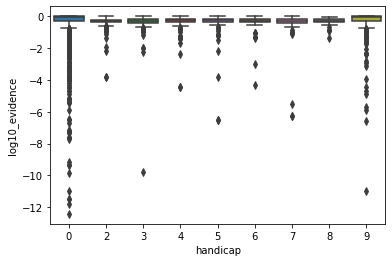

In [76]:
# sns.countplot(data=df_join[df_join["evidence"] <1e-4], x="handicap")
# sns.histplot(data=df_join, x="evidence", hue="handicap", bins=20, log_scale=(True,True), palette="tab10", multiple="stack")
sns.boxplot(data=df_join, x="handicap", y="log10_evidence")

<AxesSubplot:xlabel='winner', ylabel='log10_evidence'>

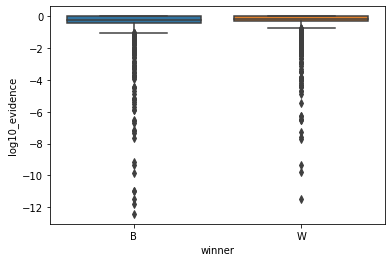

In [45]:
sns.boxplot(data=df_join, x="winner", y="log10_evidence")

<AxesSubplot:xlabel='event_id', ylabel='count'>

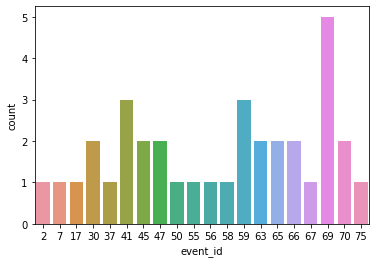

In [53]:
sns.countplot(data=df_join[df_join["log10_evidence"] < -5], x="event_id")

<AxesSubplot:xlabel='age_in_days', ylabel='log10_evidence'>

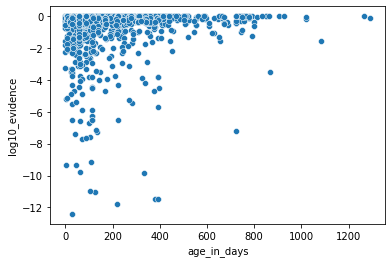

In [75]:
sns.scatterplot(data=df_join, x="age_in_days", y="log10_evidence")

<AxesSubplot:xlabel='category_mu_diff_black', ylabel='log10_evidence'>

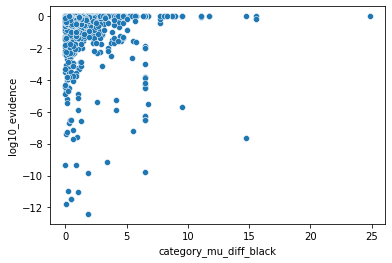

In [79]:
sns.scatterplot(data=df_join, x="category_mu_diff_black", y="log10_evidence")

<AxesSubplot:xlabel='category_mu_diff_white', ylabel='log10_evidence'>

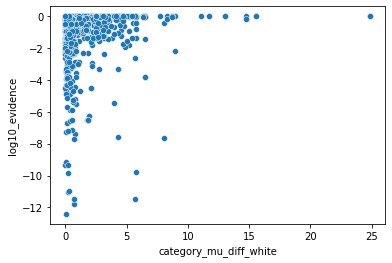

In [80]:
sns.scatterplot(data=df_join, x="category_mu_diff_white", y="log10_evidence")